In [131]:
#Importing libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [132]:
# --- Step 1: Download the Data ---
data = yf.download("AAPL", start="2015-01-01", end="2023-12-31" , auto_adjust=False)
data['Adj Close'] = yf.download("AAPL", start="2015-01-01", end="2023-12-31", auto_adjust=False)['Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [133]:
#saving as csv
data.to_csv("../data/AAPL_9y.csv")


# Exploratory Data Analysis (EDA)
In this section, we analyze Appel's historical stock data (2015–2023) to understand price trends, volatility, and feature relationships.


In [134]:
print("Data Shape",data.shape)
print(data.info())

Data Shape (2264, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2015-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  2264 non-null   float64
 1   (Close, AAPL)      2264 non-null   float64
 2   (High, AAPL)       2264 non-null   float64
 3   (Low, AAPL)        2264 non-null   float64
 4   (Open, AAPL)       2264 non-null   float64
 5   (Volume, AAPL)     2264 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 123.8 KB
None


In [135]:
display(data.head())

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2015-01-02,27.332500,27.332500,27.860001,26.837500,27.847500,212818400
2015-01-05,26.562500,26.562500,27.162500,26.352501,27.072500,257142000
2015-01-06,26.565001,26.565001,26.857500,26.157499,26.635000,263188400
2015-01-07,26.937500,26.937500,27.049999,26.674999,26.799999,160423600
2015-01-08,27.972500,27.972500,28.037500,27.174999,27.307501,237458000


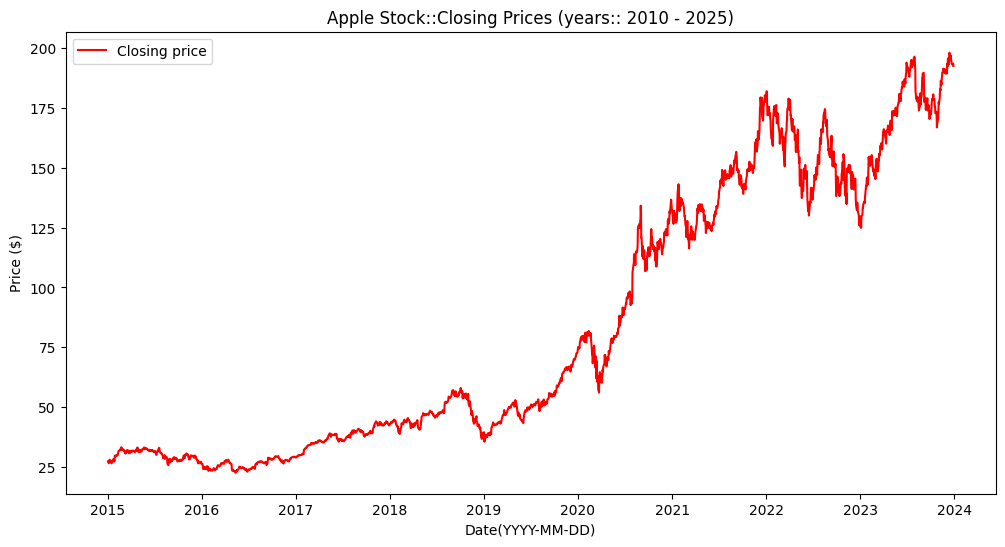

In [136]:
plt.figure(figsize=(12,6))
plt.plot(data["Close"],label="Closing price", color="red")
plt.title("Apple Stock::Closing Prices (years:: 2010 - 2025)")
plt.xlabel("Date(YYYY-MM-DD)")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

# Plotting Volume
number of shares traded each day

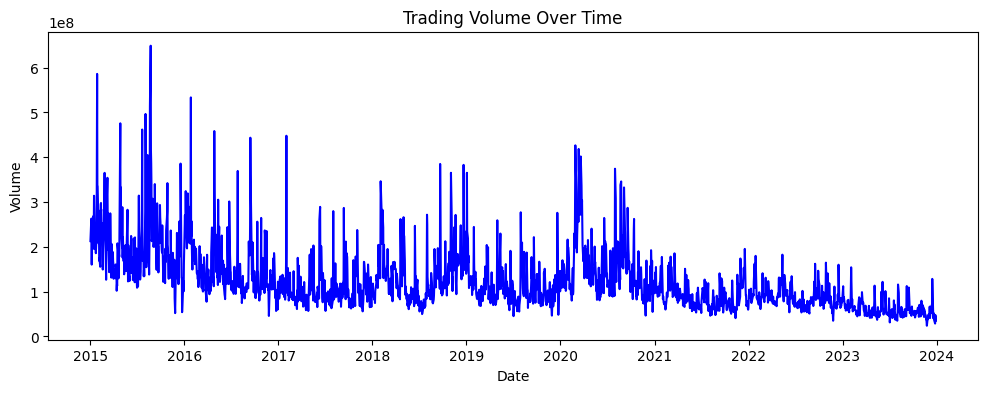

In [7]:
plt.figure(figsize=(12,4))
plt.plot(data['Volume'], color='blue')
plt.title("Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

 # Moving Averages
 Moving averages help smooth out noise and spot long-term trends

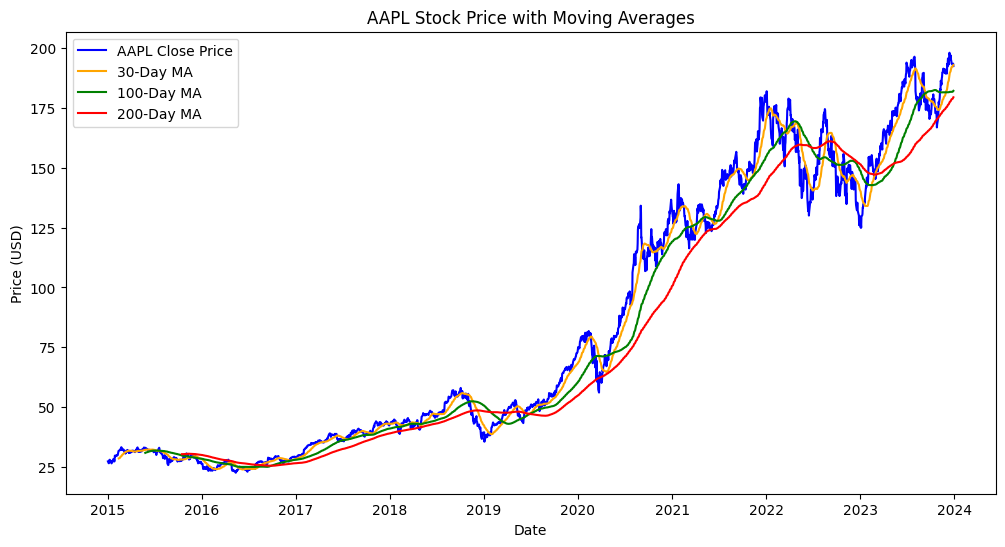

In [138]:
# Calculate moving averages
data['MA30'] = data['Close'].rolling(window=30).mean()
data['MA100'] = data['Close'].rolling(window=100).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='AAPL Close Price', color='blue')
plt.plot(data['MA30'], label='30-Day MA', color='orange')
plt.plot(data['MA100'], label='100-Day MA', color='green')
plt.plot(data['MA200'], label='200-Day MA', color='red')

plt.title("AAPL Stock Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


 # Daily Returns Histogram
 Shows volatility distribution — useful for risk analysis.

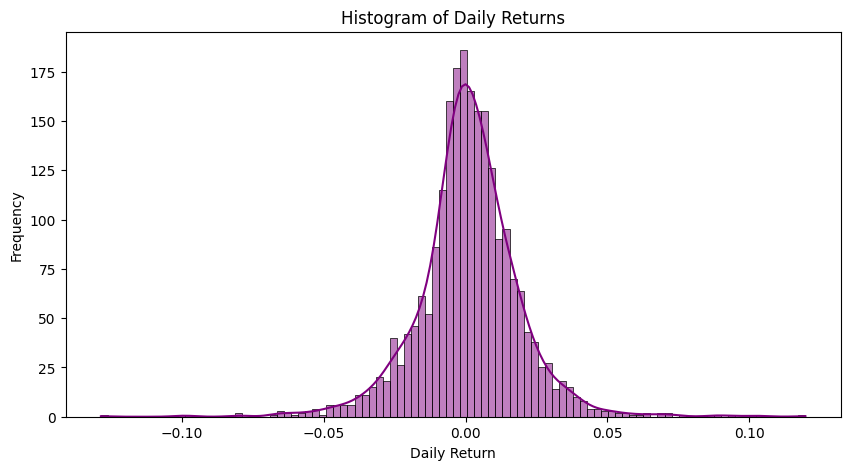

In [139]:
data['Daily Return'] = data['Close'].pct_change()
plt.figure(figsize=(10,5))
sns.histplot(data['Daily Return'].dropna(), bins=100, kde=True, color='purple')
plt.title("Histogram of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()

# Correlation Heatmap
Quickly shows relationships between features (e.g., Close vs. Volume).

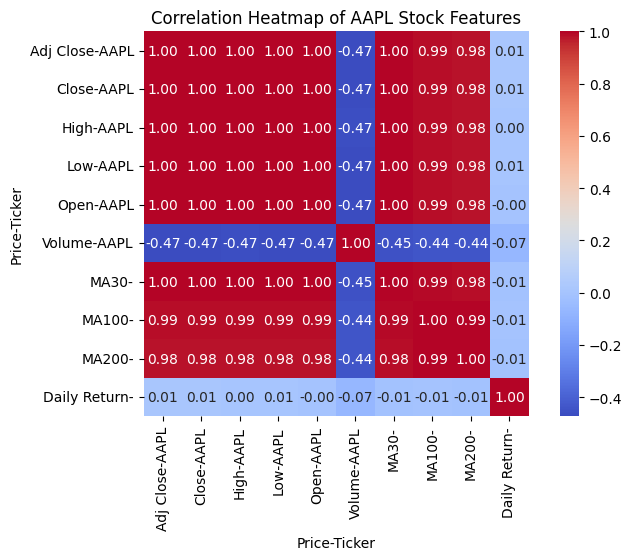

In [140]:
plt.figure(figsize=(8,5))
sns.heatmap(
    data.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",        # show 2 decimal places
    cbar=True,
    square=True
)
plt.title("Correlation Heatmap of AAPL Stock Features")
plt.show()


## Correlation Analysis of AAPL Stock Features

To understand the relationships among different stock features, we plotted a correlation heatmap.  

### Key Observations:
- **OHLC Features (Open, High, Low, Close, Adj Close)**  
  - All exhibit correlations above **0.99** with each other.  
  - This indicates they carry redundant information. For modeling, using only one (typically **Adj Close**) is sufficient.  

- **Moving Averages (MA30, MA100, MA200)**  
  - Strongly correlated with Close prices (>0.98).  
  - While they don’t introduce entirely new inform


In [11]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume,MA30,MA100,MA200,Daily Return
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,
Date,,,,,,,,,,
2015-01-02,27.332500,27.332500,27.860001,26.837500,27.847500,212818400,NaN,NaN,NaN,NaN
2015-01-05,26.562500,26.562500,27.162500,26.352501,27.072500,257142000,NaN,NaN,NaN,-0.028172
2015-01-06,26.565001,26.565001,26.857500,26.157499,26.635000,263188400,NaN,NaN,NaN,0.000094
2015-01-07,26.937500,26.937500,27.049999,26.674999,26.799999,160423600,NaN,NaN,NaN,0.014022
2015-01-08,27.972500,27.972500,28.037500,27.174999,27.307501,237458000,NaN,NaN,NaN,0.038422


# Feature Engineering for Stock Prediction
 We create lag features, rolling statistics, and technical indicators to make our data model-ready.

In [141]:
# -----------------------------
# Load and Clean Data
# -----------------------------


def load_and_clean_stock_data(filepath):
    df = pd.read_csv(filepath)

    # Ensure Date column exists & set as index
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
        df = df.set_index('Date')

    # Convert all numeric columns properly
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Check if "Close" exists
    if 'Close' not in df.columns:
        raise ValueError(f"'Close' column not found in data. Available: {list(df.columns)}")

    # Drop rows without Close
    df = df.dropna(subset=['Close'])

    return df




In [142]:
# -----------------------------
# Feature Engineering (Simple)
# -----------------------------
def add_features(df):
    if 'Close' not in df.columns:
        return df  # nothing to add if no Close

    # Lag Features
    df['Close_Lag1'] = df['Close'].shift(1)
    df['Close_Lag5'] = df['Close'].shift(5)

    # Daily Return
    df['Daily_Return'] = df['Close'].pct_change()

    # Moving Averages
    df['MA30'] = df['Close'].rolling(window=30).mean()
    df['MA100'] = df['Close'].rolling(window=100).mean()

    # Volatility (20-day rolling std)
    df['Volatility_20'] = df['Close'].pct_change().rolling(window=20).std()

    return df


In [143]:
# -----------------------------
# Manual Correlation Check
# -----------------------------
def correlation_with_target(df, target_col='Close'):
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found. Available: {list(df.columns)}")

    corr_dict = {}
    for col in df.columns:
        if col != target_col:
            valid = df[[target_col, col]].dropna()
            if not valid.empty:
                corr = valid[target_col].corr(valid[col])
                corr_dict[col] = corr
    return corr_dict



In [144]:
data = load_and_clean_stock_data("../data/AAPL_9y.csv")
data = add_features(data)

# Compute correlations
corrs = correlation_with_target(data, 'Close')

# Sort features by absolute correlation
sorted_corrs = sorted(corrs.items(), key=lambda x: abs(x[1]), reverse=True)

print("Feature Correlation with Close Price:")
for feature, corr in sorted_corrs:
    print(f"{feature:15s} : {corr:.4f}")

# Keep only useful features (strong correlation)
important_features = [f for f, c in sorted_corrs if abs(c) > 0.2]  # threshold chosen manually
print("\nSelected Important Features:", important_features)

# Final dataset
final_data = data[['Close'] + important_features].dropna()
print("\nFinal Shape:", final_data.shape)
print(final_data.head())
data = final_data
data.head()

Feature Correlation with Close Price:
Adj Close       : 1.0000
Low             : 0.9998
High            : 0.9998
Open            : 0.9996
Close_Lag1      : 0.9995
Close_Lag5      : 0.9976
MA30            : 0.9955
MA100           : 0.9872
Volume          : -0.4701
Volatility_20   : 0.0863
Daily_Return    : 0.0149

Selected Important Features: ['Adj Close', 'Low', 'High', 'Open', 'Close_Lag1', 'Close_Lag5', 'MA30', 'MA100', 'Volume']

Final Shape: (2165, 10)
         Close  Adj Close        Low       High       Open  Close_Lag1  \
101  33.009998  33.009998  32.512501  33.064999  32.584999   32.404999   
102  32.945000  32.945000  32.775002  32.987499  32.965000   33.009998   
103  32.570000  32.570000  32.474998  32.862499  32.807499   32.945000   
104  32.634998  32.634998  32.512501  32.847500  32.570000   32.570000   
105  32.490002  32.490002  32.330002  32.665001  32.465000   32.634998   

     Close_Lag5       MA30      MA100       Volume  
101   32.517502  32.091250  30.884225  18

,Close,Adj Close,Low,High,Open,Close_Lag1,Close_Lag5,MA30,MA100,Volume
101,33.009998,33.009998,32.512501,33.064999,32.584999,32.404999,32.517502,32.091250,30.884225,183332800.0
102,32.945000,32.945000,32.775002,32.987499,32.965000,33.009998,32.514999,32.132917,30.940350,122933200.0
103,32.570000,32.570000,32.474998,32.862499,32.807499,32.945000,32.847500,32.167167,31.000425,203538000.0
104,32.634998,32.634998,32.512501,32.847500,32.570000,32.570000,33.134998,32.215416,31.061125,128451200.0
105,32.490002,32.490002,32.330002,32.665001,32.465000,32.634998,32.404999,32.235083,31.116650,134670400.0


# Stock Data Analysis – Feature Insights

### Correlation with Closing Price
| Feature        | Correlation |
|----------------|-------------|
| Adj Close      | 1.0000 |
| Low            | 0.9998 |
| High           | 0.9998 |
| Open           | 0.9996 |
| Close_Lag1     | 0.9995 |
| Close_Lag5     | 0.9976 |
| MA30           | 0.9955 |
| MA100          | 0.9872 |
| Volume         | -0.4701 |
| Volatility_20  | 0.0863 |
| Daily_Return   | 0.0149 |

---

### Selected Important Features
Based on thresholding (|correlation| > 0.2), the following features were chosen:  

- `Adj Close`  
- `Low`  
- `High`  
- `Open`  
- `Close_Lag1`  
- `Close_Lag5`  
- `MA30`  
- `MA100`  
- `Volume`  

---

### Key Insights
1. **Strong Correlations**  
   - `Adj Close`, `Low`, `High`, and `Open` are almost perfectly correlated with `Close`.  
   - This is expected since they are different views of the same stock price series.  

2. **Lag Features Work Well**  
   - `Close_Lag1` and `Close_Lag5` are also highly correlated with `Close`.  
   - This shows past prices are good predictors of the current price → useful for time-series models.  

3. **Moving Averages (MA30, MA100)**  
   - Both are strongly correlated with `Close` (0.99 and 0.98).  
   - They capture **trend information** while smoothing out short-term noise.  

4. **Volume Has Negative Correlation (-0.47)**  
   - Suggests that when trading volume increases, the price sometimes falls (possible sign of **selling pressure**).  

5. **Weak Features**  
   - `Volatility_20` and `Daily_Return` have very low correlation with `Close`.  
   - These may not help in **predicting price directly**, but they can still be useful for **risk or anomaly detection**.  

---

### 🧾 Final Dataset
- **Shape**: (2165 rows × 10 columns)  
- **Features included**:  
  `Close`, `Adj Close`, `Low`, `High`, `Open`, `Close_Lag1`, `Close_Lag5`, `MA30`, `MA100`, `Volume`  

---

**Next Steps**  
- Visualize `Close` vs `MA30` and `MA100` to see trend-following signals.  
- Analyze how `Volume` spikes align with price drops.  
- Build a **regression or ML model** using the selected features.  


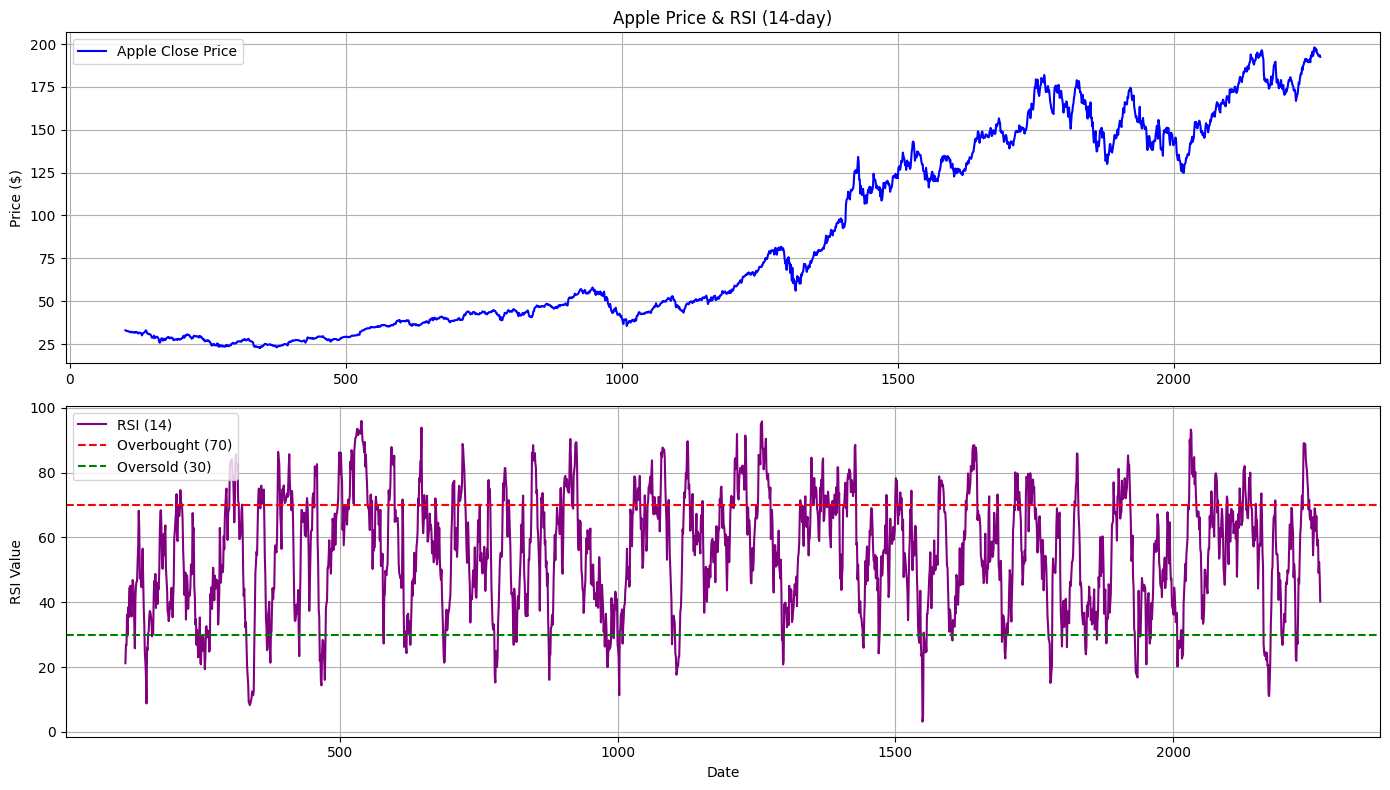

In [146]:

# --- RSI Computation ---
def compute_RSI(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain, index=series.index).rolling(window=period).mean()
    avg_loss = pd.Series(loss, index=series.index).rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add RSI to DataFrame
data['RSI_14'] = compute_RSI(data['Close'], 14)

# --- Plot Price & RSI ---
plt.figure(figsize=(14, 8))

# Top: Closing Price
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Close'], label="Apple Close Price", color='blue')
plt.title("Apple Price & RSI (14-day)")
plt.ylabel("Price ($)")
plt.legend(loc="upper left")
plt.grid()

# Bottom: RSI
plt.subplot(2, 1, 2)
plt.plot(data.index, data['RSI_14'], label="RSI (14)", color='purple')
plt.axhline(70, color='red', linestyle='--', label="Overbought (70)")
plt.axhline(30, color='green', linestyle='--', label="Oversold (30)")
plt.ylabel("RSI Value")
plt.xlabel("Date")
plt.legend(loc="upper left")
plt.grid()

plt.tight_layout()
plt.show()


In [19]:
# Keep a backup of original data
data_raw = data.copy()

# Drop rows with NA (from RSI, MA100, etc.)
data = data.dropna()

print("Original Shape:", data_raw.shape)
print("Cleaned Shape :", data.shape)


Original Shape: (2165, 11)
Cleaned Shape : (2152, 11)


### Handling Missing Values from Feature Engineering

When computing rolling features like **MA100**, **RSI(14)**, or **Volatility (20-day)**, the first few rows of the dataset naturally contain `NaN` values because there is not enough historical data to calculate them.  

For example:
- The **MA100** requires 100 previous closing prices.  
- The **RSI(14)** requires 14 previous returns.  
- Hence, the first 100 rows will include missing values.  

Since our goal is to build a **predictive model**, it is important to avoid missing values, as most machine learning algorithms cannot handle `NaN` values directly.  
There are different approaches:  

- **Fill values (ffill/bfill):** Not reliable here, because it distorts the technical indicators.  
- **Drop missing rows:** The most robust choice, since the number of missing rows is very small compared to the full dataset (~9 years of stock data).  

Therefore, we drop all rows with missing values while keeping a backup of the original dataset for reference and analysis.  


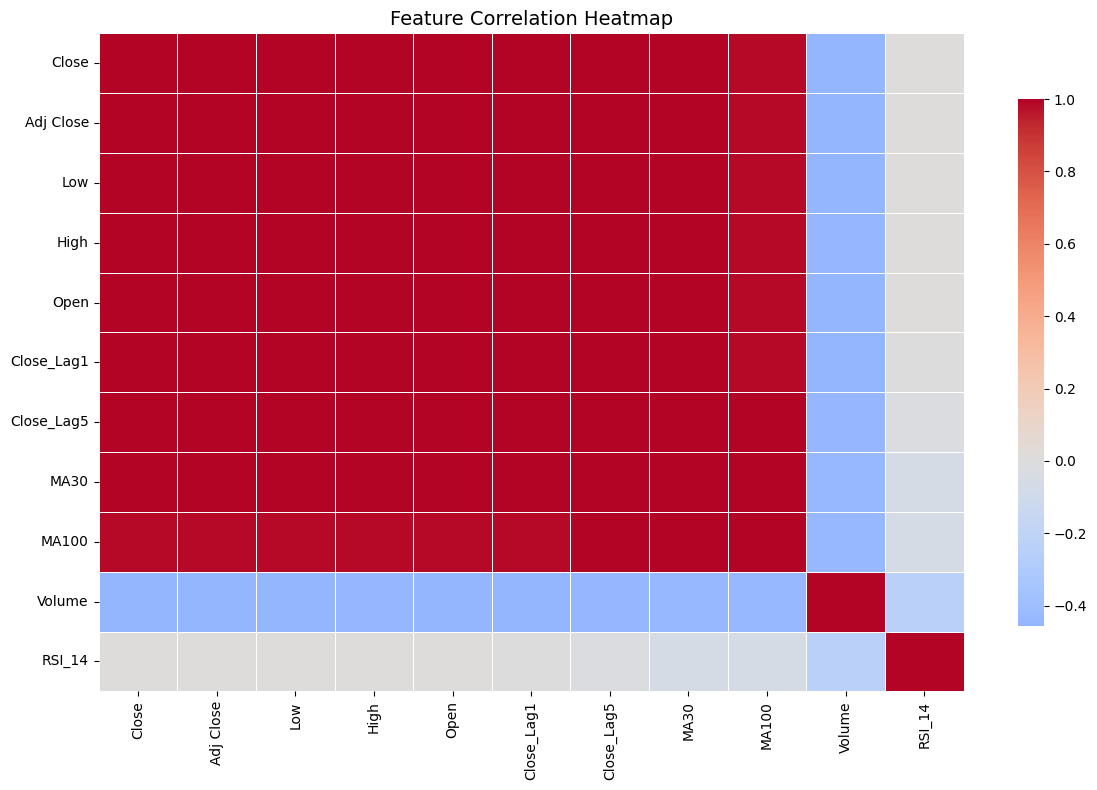

In [20]:

import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=False,   # set True if you want numbers
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)

plt.title("Feature Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()


##  Correlation Analysis Insights

1. **Highly Correlated Features**
   - `Close`, `Adj Close`, `Open`, `High`, and `Low` are **extremely correlated** with each other (correlation ≈ 1.0).  
      This is expected since they are different price measures of the same stock.  
      Keeping all of them can introduce **multicollinearity** in models.

2. **Moving Averages (MA30, MA100)**
   - Both `MA30` and `MA100` show **very high correlation** with `Close`.  
      They don’t add much independent information beyond `Close`.

3. **Lagged Features**
   - `Close_Lag1` and `Close_Lag5` also have very high correlation with `Close`.  
      They are useful for time-series forecasting but might cause **redundancy** in non-sequential models.

4. **Volume**
   - `Volume` has a **low negative correlation (~ -0.4)** with price features.  
      This suggests that trading volume and price move differently, so `Volume` may provide **independent predictive power**.

5. **RSI (14)**
   - `RSI_14` shows a **moderate correlation** with price (~0.4–0.5).  
      This makes RSI valuable as it captures **momentum/overbought-oversold signals** not explained by raw price.

---

###  Implication for Modeling
- **Multicollinearity Risk**: Features like `Open`, `High`, `Low`, `Close`, and `Adj Close` are redundant. You can keep just **one (e.g., `Close`)** or use PCA/regularization.  
- **Useful Predictors**: `Volume` and `RSI_14` bring new information beyond price.  
- **Lag Features** are important for time-series models (e.g., ARIMA, LSTM) but might need careful selection in regression-type models.


# # Stage 3.1 – Data Preparation for Modeling

# Feature Selection for Linear Regression (Ridge & Lasso)

To avoid **data leakage**, we must ensure that all features are based only on 
information available **up to time t** when predicting `Close(t+1)`.

## Rules for Avoiding Leakage
1. The target is `Close(t+1)` (next-day closing price).
2. Features must be shifted/rolled so they only use data available on or before day *t*.
3. The train/test split must be **time-based**, not random.
4. We avoid features that are too collinear with the target (e.g., `Open`, `High`, `Low`, `Adj Close`).

## Final Feature Set
- **Close_Lag1** : Previous day’s closing price.  
- **Close_Lag5** : Closing price from 5 days ago (weekly effect).  
- **MA30** : 30-day moving average (shifted so it excludes day *t+1*).  
- **MA100** : 100-day moving average (shifted properly).  
- **RSI_14** : 14-day Relative Strength Index (momentum signal, shifted).  
- **Volume** : Trading volume of the day.

## Target
- **Close(t+1)** : The next day’s closing price.

This ensures the model does not peek into the future, preventing data leakage.  
We will use Ridge and Lasso regression for robust linear modeling and feature selection.  


In [21]:
# --- Create a separate copy for Linear Regression ---
data_lr = data.copy()

# Create lag features
data_lr['Close_Lag1'] = data_lr['Close'].shift(1)
data_lr['Close_Lag5'] = data_lr['Close'].shift(5)

# Moving averages (shifted to avoid leakage)
data_lr['MA30'] = data_lr['Close'].shift(1).rolling(window=30).mean()
data_lr['MA100'] = data_lr['Close'].shift(1).rolling(window=100).mean()

# RSI shifted
data_lr['RSI_14'] = data_lr['RSI_14'].shift(1)

# Target (next-day close)
data_lr['Target'] = data_lr['Close'].shift(-1)

# Drop rows with NA caused by shifting/rolling
data_lr = data_lr.dropna()

print("Shape of original data :", data.shape)
print("Shape of LR dataset    :", data_lr.shape)


Shape of original data : (2152, 11)
Shape of LR dataset    : (2051, 12)


In [23]:
# --- Features & Target for Linear Regression ---
features_lr = ['Close_Lag1', 'Close_Lag5', 'MA30', 'MA100', 'RSI_14']
target_lr = 'Target'

X = data_lr[features_lr]
y = data_lr[target_lr]
# --- Chronological Train-Test Split (75% train, 25% test) ---
split = int(len(X) * 0.75)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size :", X_test.shape, y_test.shape)

Training set size: (1538, 5) (1538,)
Testing set size : (513, 5) (513,)


In [24]:
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    # Works with any sklearn version
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

# --- Train on data_lr split you already made ---
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

lasso = Lasso(alpha=0.001, max_iter=10000)  # more iters for stability
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

print("Ridge MSE :", mean_squared_error(y_test, ridge_pred))
print("Ridge RMSE:", rmse(y_test, ridge_pred))

print("Lasso MSE :", mean_squared_error(y_test, lasso_pred))
print("Lasso RMSE:", rmse(y_test, lasso_pred))


Ridge MSE : 16.846533173377857
Ridge RMSE: 4.104452847016013
Lasso MSE : 16.844911076643186
Lasso RMSE: 4.1042552401919625


### Ridge vs Lasso Regression Results

Both **Ridge** and **Lasso** regression models were applied to the prepared dataset (`data_lr`) to predict the next-day closing price.  
The evaluation was performed using a **75%-25% chronological split** to avoid any look-ahead bias or data leakage.

**Results:**
- Ridge MSE: ≈ 16.85  
- Ridge RMSE: ≈ 4.10  
- Lasso MSE: ≈ 16.84  
- Lasso RMSE: ≈ 4.10  

**Interpretation:**
- Both Ridge and Lasso produced almost identical performance, suggesting that the feature set is well-prepared and stable.  
- The similarity in results indicates that **multicollinearity is not significantly impacting model performance**, as Ridge usually handles correlated features better.  
- Lasso did not shrink many coefficients to zero at the chosen regularization strength (α = 0.001), behaving similarly to Ridge. This implies that **most of the features are contributing useful signal** to the model.  
- The relatively low RMSE (~4) compared to the stock price range shows that the models are capturing meaningful patterns, although further tuning may improve results.


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# --- 1. Create a Separate Copy for the Random Forest Model ---
# We select only the essential source columns to avoid multicollinearity from the start.
# 'Close' is for creating features/target, 'Volume' and 'RSI_14' are good independent features.
data_rf = data[['Close', 'Volume', 'RSI_14']].copy()

# --- 2. Feature Engineering (Leakage-Proof) ---
# All features are created using shifted (past) data.

# Lagged features
data_rf['Close_Lag1'] = data_rf['Close'].shift(1)
data_rf['Volume_Lag1'] = data_rf['Volume'].shift(1)
data_rf['RSI_14_Lag1'] = data_rf['RSI_14'].shift(1)

# Lagged Moving Averages
data_rf['MA_10'] = data_rf['Close'].shift(1).rolling(window=10).mean()
data_rf['MA_50'] = data_rf['Close'].shift(1).rolling(window=50).mean()

# --- 3. Define the Target Variable ---
# The target is the next day's closing price.
data_rf['Target'] = data_rf['Close'].shift(-1)

# --- 4. Final Data Cleaning ---
# Drop original columns that were used to create features
# and any rows with NA values from the shifting/rolling process.
data_rf = data_rf.drop(columns=['Close', 'Volume', 'RSI_14'])
data_rf = data_rf.dropna()

# --- 5. Define Features (X) and Target (y) ---
X = data_rf.drop('Target', axis=1)
y = data_rf['Target']

# --- 6. Split Data into Training and Testing Sets (Chronologically) ---
# We use shuffle=False to ensure the test set is more recent than the train set.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# --- 7. Initialize and Train the Random Forest Model ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("Training the Random Forest model...")
rf_model.fit(X_train, y_train)
print("Model training complete.")

# --- 8. Make Predictions and Evaluate ---
print("\nMaking predictions on the test data...")
predictions = rf_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("\n--- Model Evaluation ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print("------------------------")

# --- 9. Check Feature Importance ---
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Feature Importances ---")
print(feature_importances)
print("---------------------------")


Training the Random Forest model...
Model training complete.

Making predictions on the test data...

--- Model Evaluation ---
Mean Squared Error (MSE): 110.4665
Mean Absolute Error (MAE): 7.7168
R-squared (R²): 0.6928
------------------------

--- Feature Importances ---
       feature  importance
3        MA_10    0.419132
4        MA_50    0.349260
0   Close_Lag1    0.230876
2  RSI_14_Lag1    0.000408
1  Volume_Lag1    0.000324
---------------------------


## Analysis of Random Forest Model Performance
Based on the model's output, here is a detailed analysis of its performance and the key takeaways.

## 1. Overall Model Performance
The model's performance provides a solid baseline but also highlights areas for improvement.

R-squared (R²): 0.6928

Interpretation: This is a key metric. It means that our model's features (lagged prices, moving averages, etc.) can explain approximately 69.3% of the movement (variance) in the next day's stock price.

Verdict: A score of ~70% is a respectable starting point. It indicates that the model has definitely learned meaningful patterns from the data. However, for financial forecasting, there is still a significant portion (about 30.7%) of the price movement that the model is not able to capture.

Mean Absolute Error (MAE): 7.7168

Interpretation: On average, the model's price predictions are off by approximately $7.72 from the actual next-day closing price.

Context is Key: Whether this error is acceptable depends entirely on the stock's price. If this is a stock trading at $500, an error of ~$7.72 might be reasonable. If the stock trades at $50, this error is very high and the model is not practically useful.

Mean Squared Error (MSE): 110.4665

Interpretation: This metric squares the errors before averaging them, which means it heavily penalizes larger prediction mistakes. It's less intuitive than MAE but is often used to optimize a model during training. The square root of the MSE (RMSE) would be ~10.51, which gives another perspective on the error in the units of the stock price.

## 2. Feature Importance Analysis
This is the most insightful part of the output. It tells us what the model is paying attention to.

Feature

Importance

Analysis

MA_10

0.419

(Most Important) The 10-day moving average is the single most influential factor. This shows that the recent, short-term price trend is the primary driver of the model's predictions.

MA_50

0.349

(Very Important) The 50-day moving average, representing the medium-term trend, is the second most important feature.

Close_Lag1

0.231

(Important) The previous day's closing price is a strong predictor, acting as a baseline for the next day's price.

RSI_14_Lag1

0.0004

(Not Important) The model found the lagged RSI to have almost no predictive power.

Volume_Lag1

0.0003

(Not Important) Similarly, the lagged trading volume was deemed irrelevant by the model for making its predictions.

Key Takeaway: The model is essentially a trend-following model. It has learned that the best predictors of the next day's price are the short-term and medium-term trends, along with yesterday's price. It is ignoring momentum (RSI) and volume indicators entirely.

## 3. Conclusion and Next Steps
Conclusion: The model has successfully been trained without data leakage and shows a decent ability to predict future price direction based on past trends. However, its high reliance on only a few features and its moderate error suggest it can be significantly improved.

Recommended Next Steps:

Hyperparameter Tuning: The current Random Forest model uses default settings. You can likely improve the R² score and lower the MAE by tuning its parameters (e.g., n_estimators, max_depth, min_samples_leaf) using GridSearchCV or RandomizedSearchCV.

Advanced Feature Engineering: Since RSI_14_Lag1 and Volume_Lag1 were not useful, they could be removed. Instead, create new features that might capture more complex dynamics:

Volatility: Calculate the rolling standard deviation of the close price (data_rf['Close'].shift(1).rolling(window=10).std()).

Momentum: Create features that measure the rate of change over different periods (e.g., 5-day price change, 10-day price change).

Interaction Features: Create features that combine existing ones (e.g., MA_10 / MA_50 ratio).

Try a Different Model: Consider using a Gradient Boosting model like XGBoost or LightGBM. They are often more powerful than Random Forest and may be able to capture more subtle patterns in the data, potentially making use of the RSI and Volume features that the Random Forest ignored.

# LSTM

C:\Users\DEBARKA\AppData\Local\Temp\ipykernel_4060\4231545562.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2015-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.261044  24.729267  23.821668  24.718171  212818400
2015-01-05  23.577570  24.110146  23.391169  24.030260  257142000
2015-01-06  23.579794  23.839424  23.218085  23.641928  263188400
2015-01-07  23.910433  24.010290  23.677430  23.788384  160423600
2015-01-08  24.829130  24.886826  24.121248  24.238859  237458000


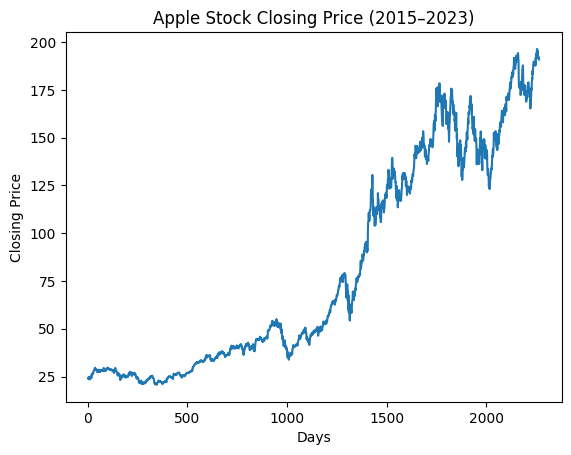

In [97]:
import yfinance as yf

# Download Apple stock data
df = yf.download("AAPL", start="2015-01-01", end="2023-12-31")

print(df.head())

df1=df.reset_index()['Close']
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("AAPL.csv")

# Take Close column and drop non-numeric values
df1 = pd.to_numeric(df['Close'], errors='coerce')  # converts bad values to NaN
df = df1.dropna()  # remove NaNs

plt.plot(df1.values)
plt.xlabel("Days")
plt.ylabel("Closing Price")
plt.title("Apple Stock Closing Price (2015–2023)")
plt.show()


In [99]:
df2=df1
  # convert to numeric
df1 = df1.ffill().bfill()  # fill forward, then backward for any initial NaN
df1 = df1.ffill()
df1

0        24.261049
1        24.261049
2        24.261049
3        23.577574
4        23.579803
           ...    
2261    191.974655
2262    191.429306
2263    191.528458
2264    191.954865
2265    190.913666
Name: Close, Length: 2266, dtype: float64

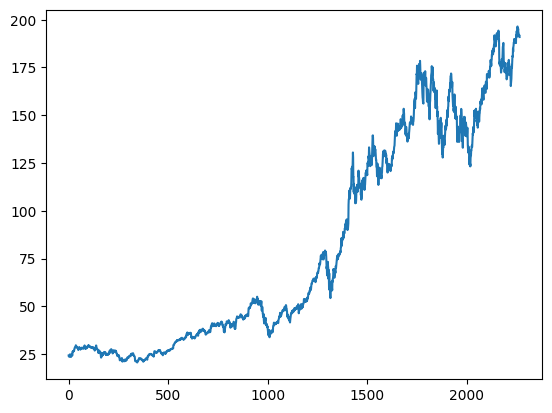

In [100]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [101]:

import numpy as np

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [102]:

##splitting dataset into train and test split
training_size=int(len(df1)*0.75)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [103]:

training_size,test_size
test_data.size

567

In [104]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [105]:

# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [106]:
print(X_train.shape), print(y_train.shape)

(1598, 100)
(1598,)


(None, None)

In [107]:
print(X_test.shape), print(ytest.shape)

(466, 100)
(466,)


(None, None)

In [108]:

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [109]:

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [110]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

C:\Users\DEBARKA\OneDrive\Desktop\stock-price-prediction\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [111]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 140ms/step - loss: 0.0230 - val_loss: 0.0022
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - loss: 4.2647e-04 - val_loss: 0.0023
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 3.9348e-04 - val_loss: 0.0022
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 3.6548e-04 - val_loss: 0.0020
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 3.9098e-04 - val_loss: 0.0019
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 3.6670e-04 - val_loss: 0.0026
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - loss: 3.8704e-04 - val_loss: 0.0018
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 3.9796e-04 - val_loss: 0.0029
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 3.7752e-04 - val_loss: 0.0025
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 3.6074e-04 - val_loss: 0.0021
Epoch

In [78]:
import tensorflow as tf
import math

In [113]:
from sklearn.metrics import mean_squared_error,r2_score
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
math.sqrt(mean_squared_error(ytest,test_predict))
r2 = r2_score(ytest, test_predict)
print("R² Score:", r2)

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
R² Score: 0.9609656016873146


In [114]:

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [115]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

66.58233336461325

In [126]:
# ### Test Data RMSE
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# math.sqrt(mean_squared_error(ytest,test_predict))
# r2 = r2_score(ytest, test_predict)
# print("R² Score:", r2)

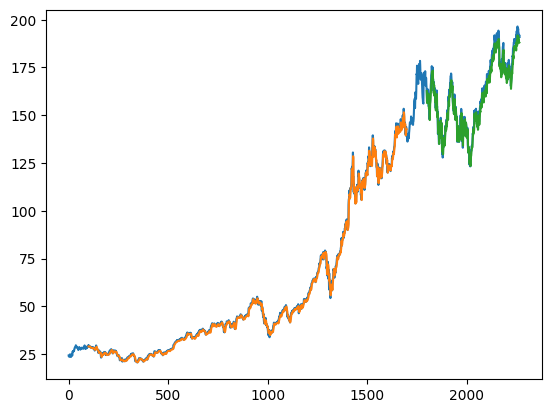

In [117]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Ongoing

In [118]:
# len(test_data)

567

In [119]:
# x_input=test_data[467:].reshape(1,-1)
# x_input.shape

(1, 100)

In [120]:
# temp_input=list(x_input)
# temp_input=temp_input[0].tolist()
# len(temp_input)

100

In [127]:
# # demonstrate prediction for next 10 days
# from numpy import array

# lst_output=[]
# n_steps=100
# i=0
# while(i<30):
    
#     if(len(temp_input)>100):
#         #print(temp_input)
#         x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
#         x_input=x_input.reshape(1,-1)
#         x_input = x_input.reshape((1, n_steps, 1))
#         #print(x_input)
#         yhat = model.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
#         temp_input.extend(yhat[0].tolist())
#         temp_input=temp_input[1:]
#         #print(temp_input)
#         lst_output.extend(yhat.tolist())
#         i=i+1
#     else:
#         x_input = x_input.reshape((1, n_steps,1))
#         yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
#         temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
#         lst_output.extend(yhat.tolist())
#         i=i+1
    

# print(lst_output)

In [122]:
# day_new=np.arange(1,101)
# # day_pred=np.arange(101,131)

In [123]:

# import matplotlib.pyplot as plt

In [129]:
# len(df1)

In [128]:

# plt.plot(day_new,scaler.inverse_transform(df1[2166:]))
# plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
# print(lst_output)

# # Example: comparing with test set
# rmse = np.sqrt(mean_squared_error(y_test, lst_output[:len(y_test)]))
# print("RMSE:", rmse)
